# Machine Learning Bird Classification
## WGU C964 Capstone


---


Michael Lawrence

mlaw101@wgu.edu

002680987

### Download the BIRDS 525 dataset
https://www.kaggle.com/datasets/gpiosenka/100-bird-species

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
License(s): CC0-1.0
100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


Check if files have already been extracted and extract them if needed

In [ ]:
import zipfile
import os

dir1 = '/content/test'
dir2 = '/content/train'
dir3 = '/content/valid'
file1 = '/content/EfficientNetB0-525-(224 X 224)- 98.97.h5'
file2 = '/content/birds.csv'

if not (os.path.exists(dir1) and os.path.exists(dir2) and os.path.exists(dir3) and
        os.path.exists(file1) and os.path.exists(file2)):
    print("Extracting files...")
    zip_ref = zipfile.ZipFile('/content/100-bird-species.zip', 'r')
    zip_ref.extractall('/content')
    zip_ref.close()
    print("Extraction completed.")
else:
    print("Files already extracted, skipping extraction.")

Extracting files...
Extraction completed.


### Clean up file tree of unneeded files and the pre-trained model from the dataset

In [ ]:
!rm -rf /content/sample_data/
!rm -rf '/content/EfficientNetB0-525-(224 X 224)- 98.97.h5'

In [ ]:
# Clean the data of joke images added by dataset creator
!rm -rf '/content/test/LOONEY BIRDS'
!rm -rf '/content/train/LOONEY BIRDS'
!rm -rf '/content/valid/LOONEY BIRDS'

### Create needed directories

In [ ]:
!mkdir /content/checkpoints/
!touch /content/checkpoints/checkpoints.keras
!mkdir /content/models/

mkdir: cannot create directory ‘/content/checkpoints/’: File exists
mkdir: cannot create directory ‘/content/models/’: File exists


### Install and Set up Anvil.works Server

In [ ]:
!pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


### Import frameworks and libraries

In [ ]:
import anvil.server

anvil.server.connect("server_K4OUTJXF6SA44QBYQBGEQUBE-LVUPCM3LXUEPINUS")

In [ ]:
import tensorflow as tf
import io
import datetime
import random
import tensorflow.keras.backend as K

from tensorflow.keras import Sequential, models, mixed_precision
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, AvgPool2D, GlobalAveragePooling2D,
                                    Flatten, concatenate, BatchNormalization, ReLU,
                                    Dropout, Input, Reshape, Resizing, Rescaling, RandomFlip,
                                    RandomContrast, RandomZoom, RandomRotation)
from PIL import Image

print("Tensorflow Version: " + tf.__version__)

Tensorflow Version: 2.17.0


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Define global variables

In [ ]:
path_to_training_data = '/content/train'
path_to_test_data = '/content/test'
path_to_validating_data = '/content/valid'

In [ ]:
batch_size = 64
image_size = (224, 224)
input_shape = (224, 224, 3)
num_classes = 524
seed = 42
np.random.seed(42)
tf.random.set_seed(seed)

### Datasets are generated, prefetched, cached and class names are extracted.
Data Augmentation is applied to the training dataset

In [ ]:
raw_training_dataset = image_dataset_from_directory(
    path_to_training_data,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed=seed,
    shuffle=True
)

class_names = raw_training_dataset.class_names

data_augmentation_pipeline = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomContrast(0.2)
    ])

training_dataset = raw_training_dataset.map(
    lambda x, y: (data_augmentation_pipeline(x, training=True), y)
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

valid_dataset = image_dataset_from_directory(
    path_to_validating_data,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed=seed,
    shuffle=True
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = image_dataset_from_directory(
    path_to_test_data,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed=seed,
    shuffle=True
).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 84479 files belonging to 524 classes.
Found 2620 files belonging to 524 classes.
Found 2620 files belonging to 524 classes.
Found 2620 files belonging to 524 classes.


### Visualize images from datasets including after augmentation

Raw Training Dataset:


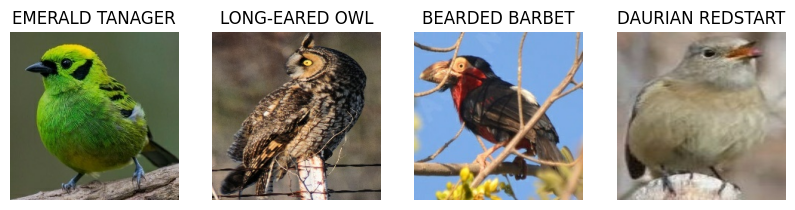

Augmented Training Dataset:


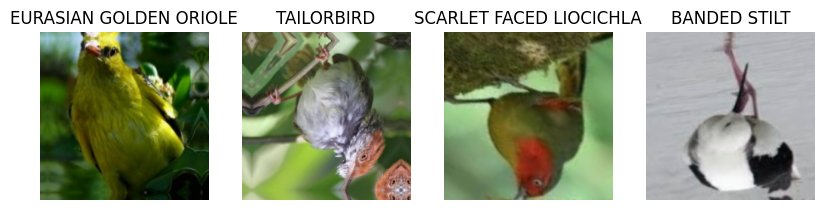

Validation Dataset:


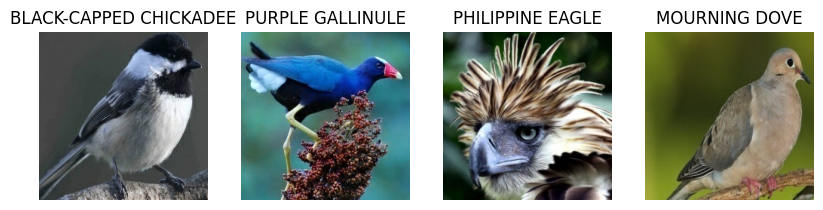

Test Dataset:


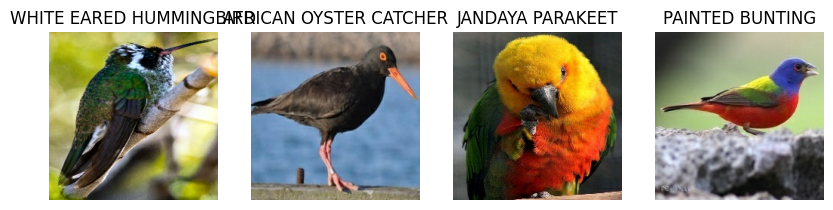

In [ ]:
def visualize_dataset(dataset, class_names, num_images=4):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy().argmax()])
            plt.axis("off")
    plt.show()

print("Raw Training Dataset:")
visualize_dataset(raw_training_dataset, class_names)

print("Augmented Training Dataset:")
visualize_dataset(training_dataset, class_names)

print("Validation Dataset:")
visualize_dataset(valid_dataset, class_names)

print("Test Dataset:")
visualize_dataset(test_dataset, class_names)

## Define the Densenet121 ML model based on the cited paper

G. Huang, Z. Liu, L. Van Der Maaten and K. Q. Weinberger, "Densely Connected Convolutional Networks," 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Honolulu, HI, USA, 2017, pp. 2261-2269, doi: 10.1109/CVPR.2017.243.

In [ ]:
def densenet(input_shape, n_classes, filters = 32, dropout_rate = 0.5):

    def convolution_layer(x, filters, kernel=1, strides=1):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x

    def dense_block(x, repetition):
        for _ in range(repetition):
            y = convolution_layer(x, 4*filters)
            y = convolution_layer(y, filters, 3)
            x = concatenate([y,x])
        return x

    def transition_layer(x):
        x = convolution_layer(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)

    for repetition in [6,12,24,16]:
        d = dense_block(x, repetition)
        x = transition_layer(d)
        x = Dropout(dropout_rate)(x)

    x = GlobalAveragePooling2D()(d)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation = 'softmax')(x)

    model = Model(input, output)
    return model

### Build the model

In [ ]:
bird_densenet = densenet(input_shape,num_classes)
bird_densenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 128)    │          8,320 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 32)     │         36,896 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 96)     │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 96)     │            384 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 96)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 128)    │         12,416 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization) 

 Total params: 7,580,748 (28.92 MB)

 Trainable params: 7,499,148 (28.61 MB)

 Non-trainable params: 81,600 (318.75 KB)

#### Plot the model and save the image to the file system
Model image is saved at '/content/model.png'

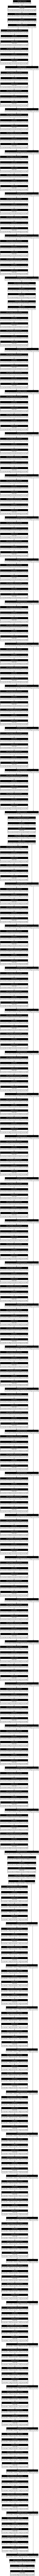

In [ ]:
plot_model(
    bird_densenet,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=40,
    show_layer_activations=True,
    show_trainable=False
)

## Prepare for training

#### Set up callback functions: ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
checkpoint_path = "/content/checkpoints/checkpoints.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=0,
    mode='max'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max')

### Compile the model

In [ ]:
bird_densenet.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

### Train the model

In [ ]:
bird_densnet_history = bird_densenet.fit(
    training_dataset,
    epochs=25,
    callbacks=[model_checkpoint, reduce_lr, early_stopping],
    validation_data=valid_dataset,
    batch_size=batch_size,
    shuffle=True
)

Epoch 1/25
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 1387s 912ms/step - accuracy: 0.0143 - loss: 6.0051 - val_accuracy: 0.0687 - val_loss: 5.0414 - learning_rate: 0.0010
Epoch 2/25
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 144s 109ms/step - accuracy: 0.1085 - loss: 4.3385 - val_accuracy: 0.1115 - val_loss: 5.4008 - learning_rate: 0.0010
Epoch 3/25
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 144s 109ms/step - accuracy: 0.2359 - loss: 3.4579 - val_accuracy: 0.2073 - val_loss: 4.6859 - learning_rate: 0.0010
Epoch 4/25
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 144s 109ms/step - accuracy: 0.3424 - loss: 2.8719 - val_accuracy: 0.3950 - val_loss: 3.0576 - learning_rate: 0.0010
Epoch 5/25
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 142s 108ms/step - accuracy: 0.4273 - loss: 2.4428 - val_accuracy: 0.3733 - val_loss: 3.4261 - learning_rate: 0.0010
Epoch 6/25
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 145s 110ms/step - accuracy: 0.4957 - loss: 2.1203 - val_accuracy: 0.4603 - val_loss: 2.9730 - learning_rate: 0.0010
Epoch 7/25
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 144s 109m

#### Save the model for future use

In [ ]:
bird_densenet.save('/content/models/bird_classification_densenet.keras')

### Generate line and bar plots displaying training and validation accuracy and loss metrics during model fitting

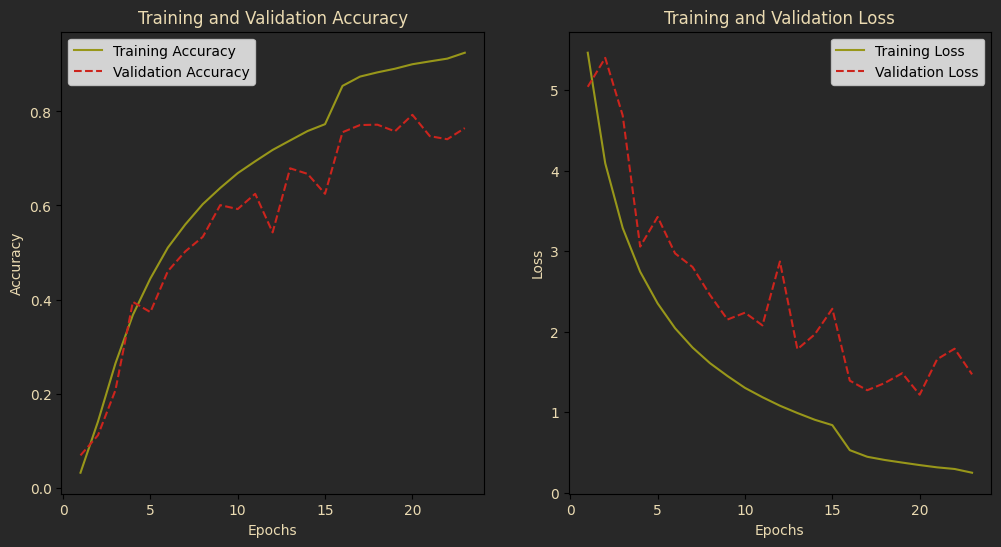

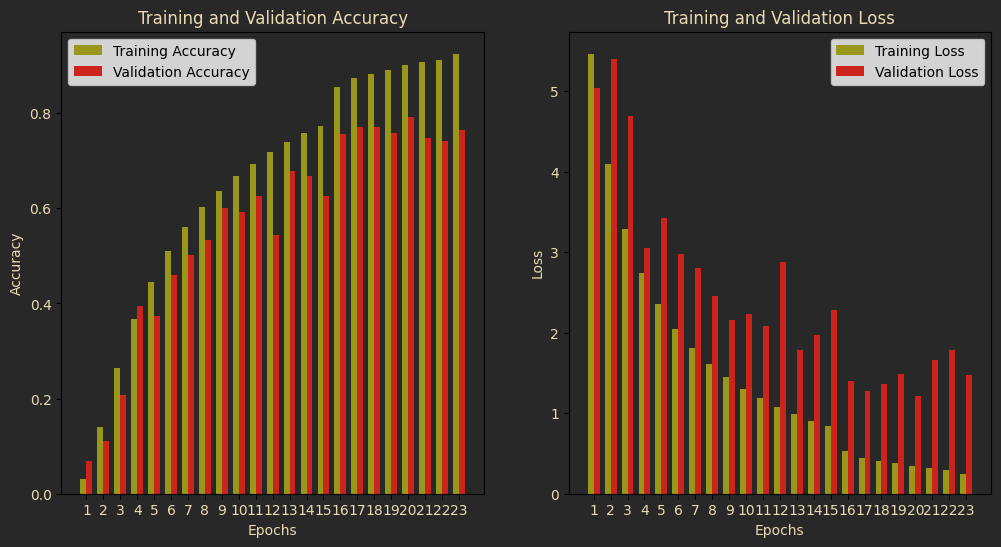

In [ ]:
def plot_training_lines(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6), facecolor='#282828')

    plt.subplot(1, 2, 1, facecolor='#282828')
    plt.plot(epochs, acc, color='#98971a', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='#cc241d', linestyle='--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', color='#ebdbb2')
    plt.xlabel('Epochs', color='#ebdbb2')
    plt.ylabel('Accuracy', color='#ebdbb2')
    plt.xticks(color='#ebdbb2')
    plt.yticks(color='#ebdbb2')
    plt.legend()

    plt.subplot(1, 2, 2, facecolor='#282828')
    plt.plot(epochs, loss, color='#98971a', label='Training Loss')
    plt.plot(epochs, val_loss, color='#cc241d', linestyle='--', label='Validation Loss')
    plt.title('Training and Validation Loss', color='#ebdbb2')
    plt.xlabel('Epochs', color='#ebdbb2')
    plt.ylabel('Loss', color='#ebdbb2')
    plt.xticks(color='#ebdbb2')
    plt.yticks(color='#ebdbb2')
    plt.legend()

    plt.show()

def plot_training_bars(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    width = 0.35

    plt.figure(figsize=(12, 6), facecolor='#282828')

    plt.subplot(1, 2, 1, facecolor='#282828')
    plt.bar(np.array(epochs) - width/2, acc, width, label='Training Accuracy', color='#98971a')
    plt.bar(np.array(epochs) + width/2, val_acc, width, label='Validation Accuracy', color='#cc241d')
    plt.title('Training and Validation Accuracy', color='#ebdbb2')
    plt.xlabel('Epochs', color='#ebdbb2')
    plt.ylabel('Accuracy', color='#ebdbb2')
    plt.xticks(epochs, color='#ebdbb2')
    plt.yticks(color='#ebdbb2')
    plt.legend()

    plt.subplot(1, 2, 2, facecolor='#282828')
    plt.bar(np.array(epochs) - width/2, loss, width, label='Training Loss', color='#98971a')
    plt.bar(np.array(epochs) + width/2, val_loss, width, label='Validation Loss', color='#cc241d')
    plt.title('Training and Validation Loss', color='#ebdbb2')
    plt.xlabel('Epochs', color='#ebdbb2')
    plt.ylabel('Loss', color='#ebdbb2')
    plt.xticks(epochs, color='#ebdbb2')
    plt.yticks(color='#ebdbb2')
    plt.legend()

    plt.show()

plot_training_lines(bird_densnet_history)
plot_training_bars(bird_densnet_history)

### Ensure the model is properly loaded and ready for use

In [ ]:
trained_model = load_model('/content/models/bird_classification_densenet.keras')

### Evaluate the model against the test data

In [ ]:
test_loss, test_accuracy = trained_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step - accuracy: 0.8117 - loss: 1.0371
Test Loss: 1.0263651609420776, Test Accuracy: 0.8152672052383423


### Generate a confusion matrix for the top-20 miss-classifications from the validation dataset

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7890 - loss: 1.2286
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


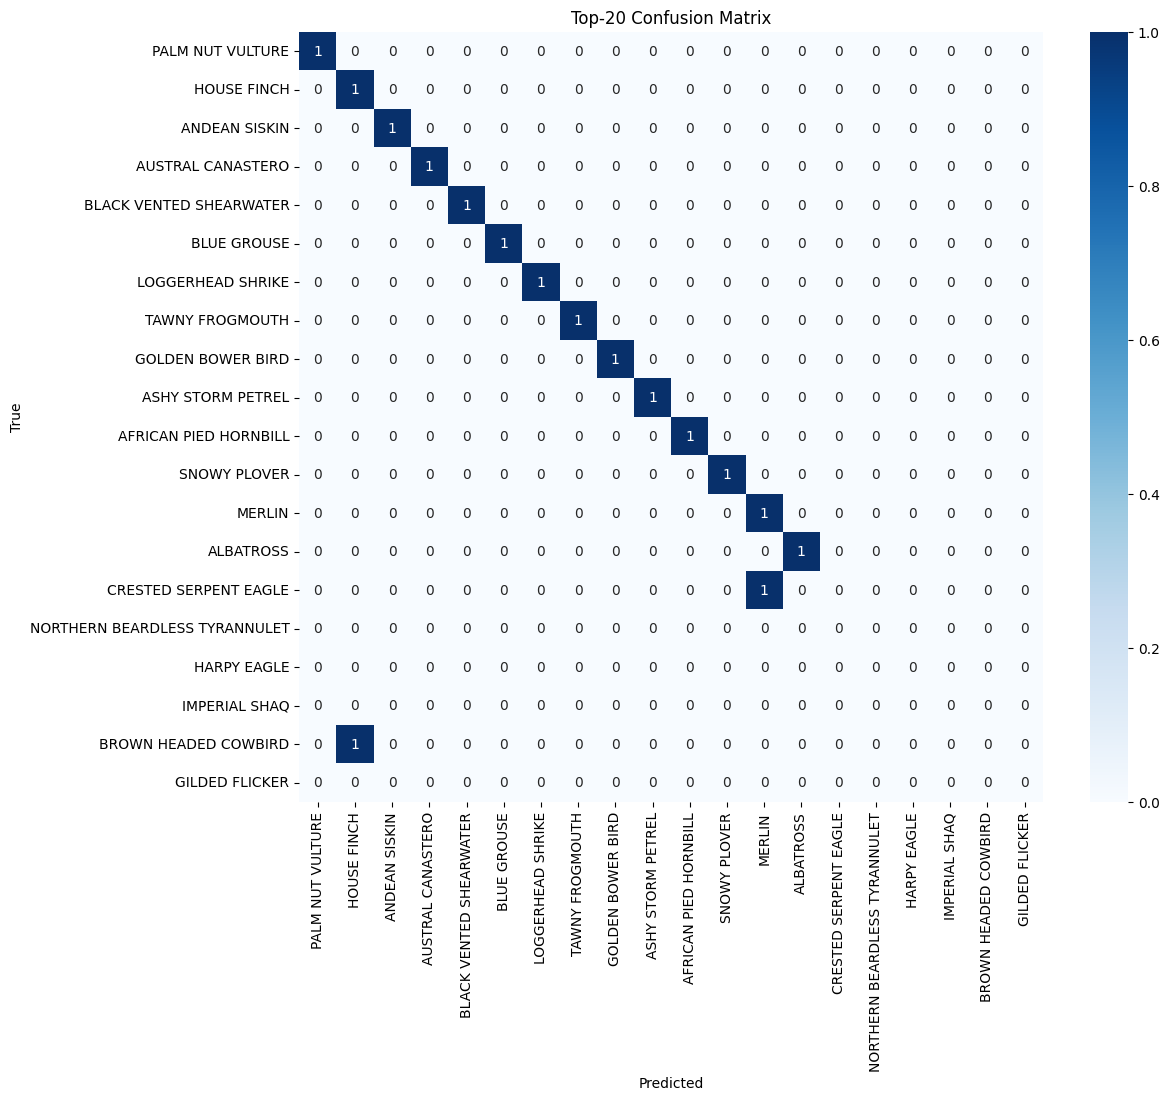

In [ ]:
trained_model.evaluate(valid_dataset)

true_labels = np.concatenate([y for x, y in valid_dataset], axis=0)
predictions = trained_model.predict(valid_dataset)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(true_labels, axis=-1)

cm = confusion_matrix(true_labels, predicted_labels)

misclassifications = np.sum(cm, axis=1) - np.diag(cm)

top_n = 20
top_n_indices = np.argsort(misclassifications)[-top_n:]

cm_top_n = cm[top_n_indices][:, top_n_indices]
class_names_top_n = [class_names[i] for i in top_n_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_top_n, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_top_n, yticklabels=class_names_top_n)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Top-{top_n} Confusion Matrix')
plt.show()

## Test model predictions

### Create functions for preprocessing images and decoding predictions

In [ ]:
target_size = image_size

def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.array([img_array])
    return img_array


In [ ]:
def decode_predictions(predictions, class_names, top=5):
    if len(predictions.shape) != 2:
        raise ValueError(f"`decode_predictions` expects a 2D array, received shape: {predictions.shape}")

    decoded_prediction = []
    for prediction in predictions:
        top_indices = prediction.argsort()[-top:][::-1]
        result = [(class_names[i], prediction[i]) for i in top_indices]
        decoded_prediction.append(result)

    return decoded_prediction

### Test model predictions on 5 test images and show the top 3 predictions and their probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: /content/test/BALD EAGLE/3.jpg
  Predicted class: BALD EAGLE, Probability: 0.8917
  Predicted class: WHITE TAILED TROPIC, Probability: 0.0946
  Predicted class: ALBATROSS, Probability: 0.0091
Image: /content/test/AMERICAN FLAMINGO/4.jpg
  Predicted class: AMERICAN FLAMINGO, Probability: 0.9993
  Predicted class: SCARLET IBIS, Probability: 0.0007
  Predicted class: BALD IBIS, Probability: 0.0000
Image: /content/test/COMMON FIRECREST/2.jpg
  Predicted class: COMMON FIRECREST, Probability: 1.0000
  Predicted class: D-ARNAUDS BARBET, Probability: 0.0000
  Predicted class: CAPE MAY WARBLER, Probability: 0.0000
Image: /content/test/CALIFORNIA GULL/4.jpg
  Predicted class: CALIFORNIA GULL, Probability: 0.9633
  Predicted class: NORTHERN FULMAR, Probability: 0.0356
  Predicted class: FAIRY TERN, Probability: 0.0006
Image: /content/test/CROW/5.jpg
  Predicted class: HAMERKOP, Probability: 0.6567
  Predicted class: BLACK VULTURE, Probability: 0.1995
 

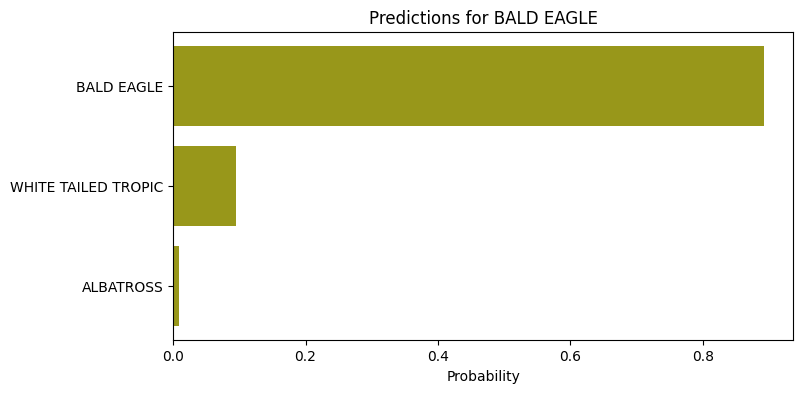

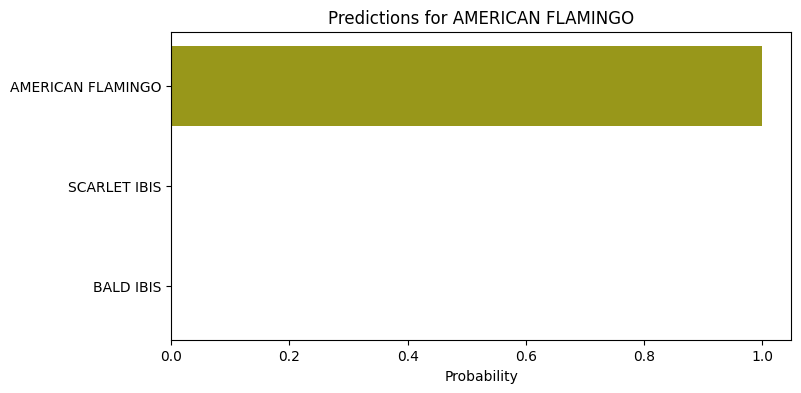

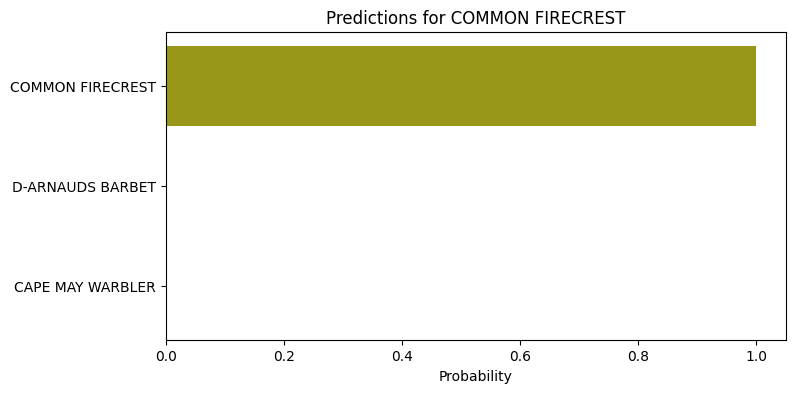

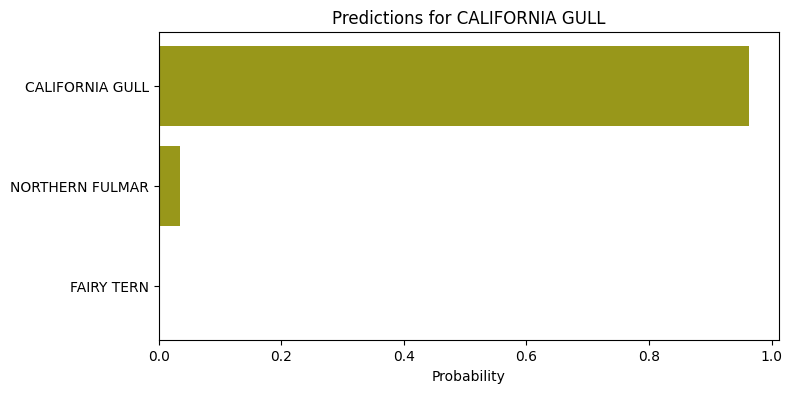

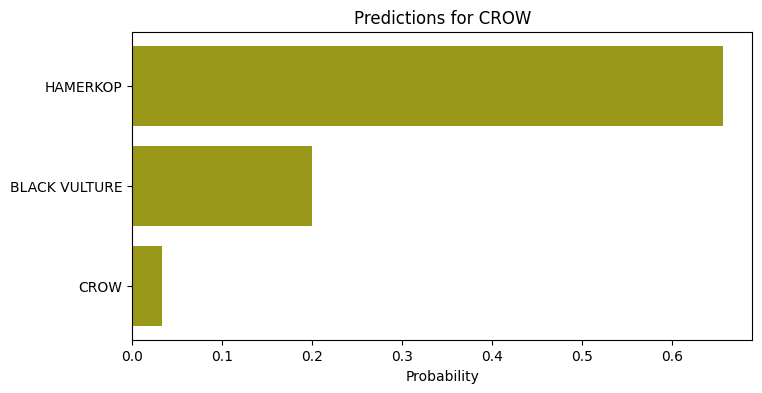

In [ ]:
image_paths = [
    '/content/test/BALD EAGLE/3.jpg',
    '/content/test/AMERICAN FLAMINGO/4.jpg',
    '/content/test/COMMON FIRECREST/2.jpg',
    '/content/test/CALIFORNIA GULL/4.jpg',
    '/content/test/CROW/5.jpg'

]

images = np.vstack([preprocess_image(img_path, target_size) for img_path in image_paths])
predictions = trained_model.predict(images)
decoded_preds = decode_predictions(predictions, class_names, top=3)

for img_path, decoded in zip(image_paths, decoded_preds):
    print(f"Image: {img_path}")
    for class_name, probability in decoded:
        print(f"  Predicted class: {class_name}, Probability: {probability:.4f}")

for img_path, decoded in zip(image_paths, decoded_preds):
    classes = [class_name for class_name, _ in decoded]
    probabilities = [probability for _, probability in decoded]

    plt.figure(figsize=(8, 4))
    plt.barh(classes, probabilities, color='#98971a')
    plt.xlabel('Probability')
    plt.title(f"Predictions for {img_path.split('/')[-2]}")
    plt.gca().invert_yaxis()
    plt.show()

### Create callable classification function that links to Anvil.Works web front end
[Link to this project's Anvil.Works Front-end implementation](https://educated-oval-iberian-lynx.anvil.app)


In [ ]:
@anvil.server.callable
def classify_image(file):
    if not file:
        return {'result': 'No file uploaded'}

    image_stream = io.BytesIO(file.get_bytes())

    processed_image = preprocess_image(image_stream, target_size)

    prediction = trained_model.predict(processed_image)
    predicted_class = np.argmax(prediction, axis=-1)[0]

    label = class_names[predicted_class]

    return {'result' : label}

In [ ]:
anvil.server.wait_forever()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


KeyboardInterrupt: 